<div class="alert alert-warning">
<b>✨ Additional Material: Data Science Series - Streamlining Invoice Processing </b>

- 💻 Detail Material: <b>Document Information Extraction (Item Detail, Price, Total Price, Company Name, and Date)</b> Using [Document Understanding Transformer](https://github.com/clovaai/donut) for Efficient Business Operations in Python
- 👩🏻‍🏫 By: Fiqey Indriati Eka Sari

© Algoritma 2024
___
</div>

# Import Library

In [1]:
import re # untuk cleaning menggunakan regex (regular expression)
import os # untuk pembacaan data image -> baca nama file
import torch

from PIL import Image # untuk membaca gambar
from transformers import DonutProcessor, VisionEncoderDecoderModel

import transformers
import gradio as gr # untuk gradio
import numpy as np

c:\Users\user\miniconda3\envs\dss_donut\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model base for extraction item detail, price, and total price
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
# load model dc (date, company) for extraction item detail, price, and total price
processor_dc = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model_dc = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## Read Dataset

In [4]:
# folder path
dir_path = '../data_input/custom/'

In [5]:
img_filenames = [] # list nama file gambar
images = [] # list objek gambar

# iterasi direktori -> looping untuk mendapatkan seluruh nama file di `data_input/valid``
for file in os.listdir(dir_path):
    if file.endswith(('.png', '.jpg', '.jpeg')): # jika file tsb berekstensi ('.png', '.jpg', '.jpeg')
        # menyimpan nama gambar ke list
        img_filenames.append(file)
        
        # membuka dan menyimpan objek gambar ke list
        images.append(Image.open(dir_path + file))


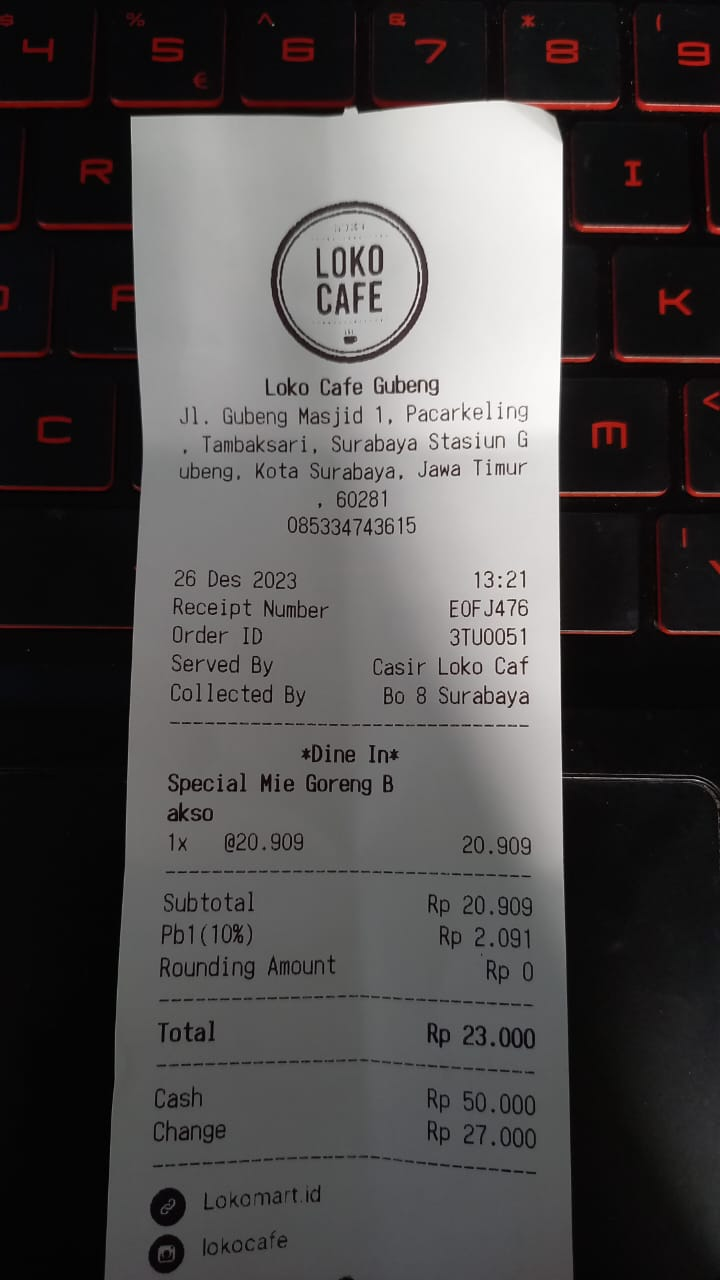

In [6]:
images[1]

### Make Custom Function for Generate Output

#### 1️⃣ Function to Generate Item Details, Item Price & Total Price

In [7]:
task_prompt = "<s_cord-v2>"

In [8]:
def doc_to_text(input_img, task_prompt=task_prompt, model=model, processor=processor):
    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    # document preprocessing
    pixel_values = processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    # sequence generation
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )
    
    # document post-processing: sequence token cleaning
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    print(sequence)

    # output conversion: token to json
    output = processor.token2json(sequence)

    return output

In [9]:
# contoh generate item details, item price & total price
doc_to_text(images[1])

<s_menu><s_nm> LOKO CAFE</s_nm><s_num> LOKO</s_num><s_price> Loko Cafe Gubeng</s_price><sep/><s_nm> Jl. Gubeng Masjid Pacarkeling</s_nm><s_num>. Tahbaksari, Surabaya Stasium G</s_nm><s_num> ubeng. Kota Surabaya. Jawa Timur</s_nm><s_num> 60281</s_num><s_price> 085334743615</s_price><sep/><s_nm> 26 Des 2023</s_num><s_price> 13:21</s_price><sep/><s_nm> Receipt Number</s_nm><s_num> EOFJ476</s_num><s_price> 3TU0051</s_price><sep/><s_nm> Order ID</s_nm><s_num> nerved By</s_nm><s_unitprice> Loko</s_nm><s_num> Coliccted By</s_nm><s_unitprice> Bo 8</s_num><s_price> Surabaya</s_price><s_sub><s_nm> Special Mie Goreng B</s_nm><s_num> akso</s_nm><s_num> *Dine In*</s_num><s_unitprice> @20.909</s_unitprice><s_cnt> 1x</s_cnt><s_price> 20.909</s_price></s_menu><s_sub_total><s_subtotal_price> Rp 20.909</s_subtotal_price><s_tax_price> Rp 2,091</s_tax_price></s_sub_total><s_total><s_total_price> Rp 23.000</s_total_price><s_cashprice> Rp 50.000</s_cashprice><s_changeprice> Rp 27.000</s_changeprice></s_tota

{'menu': [{'nm': 'LOKO CAFE', 'num': 'LOKO', 'price': 'Loko Cafe Gubeng'},
  {'nm': 'Jl. Gubeng Masjid Pacarkeling', 'price': '085334743615'},
  {'nm': {'price': '13:21'}, 'num': 'EOFJ476', 'price': '3TU0051'},
  {'nm': 'Special Mie Goreng B',
   'price': '20.909',
   'unitprice': '@20.909',
   'cnt': '1x'}],
 'sub_total': {'subtotal_price': 'Rp 20.909', 'tax_price': 'Rp 2,091'},
 'total': {'total_price': 'Rp 23.000',
  'cashprice': 'Rp 50.000',
  'changeprice': 'Rp 27.000'}}

#### 2️⃣ Function to Generate Date & Company

In [10]:
def doc_to_text_date_company(input_img, model=model_dc, processor=processor_dc, img_processor=processor):
    # prepare inputs
    task_prompt_dc = "<s>"
    pixel_values = img_processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt_dc, add_special_tokens=False, return_tensors="pt")["input_ids"]
    
    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    return prediction

In [11]:
# contoh generate date & company
doc_to_text_date_company(images[1])

{'total': '20.90',
 'date': '26 DES 2023',
 'company': 'LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1, PACARKEING',
 'address': '. TAMBAKSARI, SURABYA, JAWA Timur'}

#### Run All for 2 Example

In [12]:
preds = []
for img in images:
    out = doc_to_text(img)
    out['company_date'] = doc_to_text_date_company(img)
    preds.append(out)

<s_menu><s_nm> LOKO CAFE</s_nm><s_num> LOKO Cafe Gubeng</s_nm><s_num> Jl. Gubeng Masjid 1, Pacarkeling</s_num><s_unitprice> Surabaya Stasiun G</s_nm><s_num>,</s_num><s_unitprice> 60281</s_unitprice><s_cnt>,</s_cnt><s_price>,</s_price><sep/><s_nm> Tambaksari, Surabaya Stasiun G</s_nm><s_num> ubeng, Kota Surabaya, Jawa Timur</s_nm><s_num> 60281</s_num><s_price>,</s_price><sep/><s_nm> 26 Des 2023</s_num><s_price> 12:14</s_price><sep/><s_nm> Receipt Number</s_nm><s_num> E0FJ46S</s_num><s_price> 3TU0038</s_price><sep/><s_nm> Order ID</s_nm><s_num> SEYved By Casir Loko Cafe</s_nm><s_num> Collected By</s_nm><s_num> Bo 8</s_num><s_price> Surabaya</s_price><s_sub><s_nm> *Dine In*</s_nm></s_sub><sep/><s_nm> Belgian Wafle Ala Mo</s_nm><s_num> de</s_nm><s_unitprice> @27.273</s_unitprice><s_cnt> 1x</s_cnt><s_price> 27.273</s_price></s_menu><s_sub_total><s_subtotal_price> Rp 27.273</s_subtotal_price><s_tax_price> Rp 2.727</s_tax_price><s_etc> Rp 0)</s_etc></s_sub_total><s_total><s_total_price> Rp 30

In [13]:
import pandas as pd
df_preds = pd.DataFrame.from_dict(preds)
df_preds.head()

,menu,sub_total,total,company_date
0,"[{'nm': 'LOKO CAFE', 'unitprice': {'num': ','}...","{'subtotal_price': 'Rp 27.273', 'tax_price': '...","{'total_price': 'Rp 30.000', 'cashprice': 'Rp ...","{'total': '27.27', 'date': '26 DES 2023', 'com..."
1,"[{'nm': 'LOKO CAFE', 'num': 'LOKO', 'price': '...","{'subtotal_price': 'Rp 20.909', 'tax_price': '...","{'total_price': 'Rp 23.000', 'cashprice': 'Rp ...","{'total': '20.90', 'date': '26 DES 2023', 'com..."


In [14]:
df_preds['company_date'][0].keys()

dict_keys(['total', 'date', 'company'])

In [15]:
df_preds.loc[0,]['menu']

[{'nm': 'LOKO CAFE', 'unitprice': {'num': ','}, 'cnt': ',', 'price': ','},
 {'nm': 'Tambaksari, Surabaya Stasiun G', 'price': ','},
 {'nm': {'price': '12:14'}, 'num': 'E0FJ46S', 'price': '3TU0038'},
 {'nm': 'Order ID', 'price': 'Surabaya', 'sub': {'nm': '*Dine In*'}},
 {'nm': 'Belgian Wafle Ala Mo',
  'unitprice': '@27.273',
  'cnt': '1x',
  'price': '27.273'}]

## Data Post-Processing

In [16]:
df = pd.DataFrame(columns=['receipt_id', 'nm', 'cnt', 'price', 'total_price', 'tax_price', 'date', 'company'])
df

,receipt_id,nm,cnt,price,total_price,tax_price,date,company


In [17]:
# mengiterasi setiap rrow dalam df_preds
for index, row in df_preds.iterrows():

    # mengecek apakah field 'menu' adalah list, jika tidak, ubah menjadi list
    menus = row['menu'] if isinstance(row['menu'], list) else [row['menu']]

    # mengiterasi setiap elemen dalam list 'menus'
    for menu in menus:
        # menambahkan row baru ke 'df' dengan informasi dari 'menu' serta tambahan 'total_price' dan 'receipt_id'
        df.loc[len(df)] = {
            **menu,  # unpack semua pasangan key-value dari dictionary 'menu' yang cocok dg nama kolom yg ada
            'total_price': row['total']['total_price'],  # mengambil 'total_price' dari baris saat ini
            'tax_price': row['sub_total']['tax_price'],  # mengambil 'tax_price' dari baris saat ini
            'company': row['company_date']['company'],  # mengambil 'company' dari baris saat ini
            'date': row['company_date']['date'],  # mengambil 'date' dari baris saat ini
            'receipt_id': img_filenames[index].split('.')[0]  # mengambil ID struk dari nama file gambar
        }

In [18]:
df

,receipt_id,nm,cnt,price,total_price,tax_price,date,company
0,loko,LOKO CAFE,",",",",Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
1,loko,"Tambaksari, Surabaya Stasiun G",NaN,",",Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
2,loko,{'price': '12:14'},NaN,3TU0038,Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
3,loko,Order ID,NaN,Surabaya,Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
4,loko,Belgian Wafle Ala Mo,1x,27.273,Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
5,loko2,LOKO CAFE,NaN,Loko Cafe Gubeng,Rp 23.000,"Rp 2,091",26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...
6,loko2,Jl. Gubeng Masjid Pacarkeling,NaN,085334743615,Rp 23.000,"Rp 2,091",26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...
7,loko2,{'price': '13:21'},NaN,3TU0051,Rp 23.000,"Rp 2,091",26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...
8,loko2,Special Mie Goreng B,1x,20.909,Rp 23.000,"Rp 2,091",26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...


In [19]:
# iterasi melalui setiap baris dalam DataFrame menggunakan df.iterrows()
for index, row in df.iterrows():
    # set drop ke True secara default, artinya asumsi awal adalah akan menghapus baris
    drop = True
    
    # membersihkan dan memformat nilai 'price' dalam baris
    row['price'] = str(row['price']).replace(".", "").replace(",", "").replace("Rp", "").replace(" ", "")
    
    # memeriksa apakah nilai 'price' setelah diformat adalah numerik dan tidak diawali dengan '0'
    if row['price'].isnumeric() and not str(row['price']).startswith('0'):
        # jika memenuhi kriteria, set drop ke False agar baris tidak dihapus
        drop = False
    
    # jika drop tetap True, maka hapus baris dari DataFrame
    if drop:
        df.drop(index, inplace=True)


In [20]:
df

,receipt_id,nm,cnt,price,total_price,tax_price,date,company
4,loko,Belgian Wafle Ala Mo,1x,27.273,Rp 30.000,Rp 2.727,26 DES 2023,LOKO CAFE
8,loko2,Special Mie Goreng B,1x,20.909,Rp 23.000,"Rp 2,091",26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...


In [21]:
def clean_price(x):
    return int(x.replace(".", "").replace(",", "").replace("Rp", "").replace(" ", ""))

In [22]:
df['price'] = df['price'].apply(lambda x: clean_price(str(x)))
df['total_price'] = df['total_price'].apply(lambda x: clean_price(x))
df['tax_price'] = df['tax_price'].apply(lambda x: clean_price(x))

In [23]:
# membersihkan dan mengkonversi nilai 'x' menjadi float
def clean_quantity(x):
    # jika 'x' bernilai None (tidak ada data), kembalikan 0
    if x is None:
        return 0

    # mengonversi 'x' ke string, menghapus spasi, 'x'/'X', dan ']' dari string tersebut, dan mengembalikan menjadi sebuah angka
    return float(str(x).replace(" ", "").replace("x", "").replace("X", "").replace("]", ""))

df['cnt'] = df['cnt'].apply(lambda x: clean_quantity(x))

In [24]:
df.head()

,receipt_id,nm,cnt,price,total_price,tax_price,date,company
4,loko,Belgian Wafle Ala Mo,1.0,27273,30000,2727,26 DES 2023,LOKO CAFE
8,loko2,Special Mie Goreng B,1.0,20909,23000,2091,26 DES 2023,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...


### Transform the Date & Fill NA in Quantity

In [25]:
import locale
locale.setlocale(locale.LC_ALL, 'id_ID')

'id_ID'

In [26]:
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

In [27]:
df['cnt'].fillna(1, inplace=True)

In [28]:
df = df.rename(axis=1, mapper={'nm':'item_name',
                        'cnt': 'count'})

In [29]:
df

,receipt_id,item_name,count,price,total_price,tax_price,date,company
4,loko,Belgian Wafle Ala Mo,1.0,27273,30000,2727,2023-12-26,LOKO CAFE
8,loko2,Special Mie Goreng B,1.0,20909,23000,2091,2023-12-26,LOKO CAFE GUBEN</s_address> JL. GUBNG MASJID 1...
